In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import torch

# add path of Tangram repository for importing it
sys.path.append("./Tangram") 
import tangram as tg

## Mapping

In [2]:
path = os.path.join('data', 'corrected_ad_sp.h5ad')
ad_sp = sc.read_h5ad(path)
ad_sp

AnnData object with n_obs × n_vars = 27261 × 17919
    obs: 'x', 'y'

sc data might also be ought to only have test data because otherwise there are ones in sc data that is already mapped.

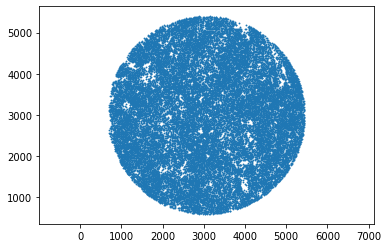

In [3]:
plt.axis('equal')
plt.scatter(ad_sp.obs.x.values, 
            ad_sp.obs.y.values, 
            s=.7)

In [3]:
sc.pp.subsample(ad_sp, fraction=0.5, random_state=0)
ad_sp

/home/myp2113/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


AnnData object with n_obs × n_vars = 13630 × 17919
    obs: 'x', 'y'

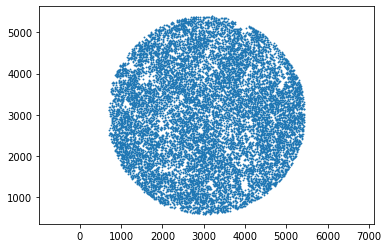

In [4]:
plt.axis('equal')
plt.scatter(ad_sp.obs.x.values, 
            ad_sp.obs.y.values, 
            s=.7)

In [5]:
# single-cell data need the following steps:
# 1. remove mitochondrial genes, which are removed in this data set
# 2. normalization
# 3. log(1+p) transformation: not necessary for mapping; necessary for selecting marker genes

path = os.path.join('data', 'corrected_ad_sc.h5ad')
ad_sc = sc.read_h5ad(path)
sc.pp.normalize_total(ad_sc)
ad_sc

AnnData object with n_obs × n_vars = 26139 × 2505
    obs: 'cluster', 'subcluster'

In [8]:
ad_sc.obs.cluster

P60CBRep1P1_GACTCTACACCC    Other Interneurons
P60CBRep1P1_TATTATATCTAA              Purkinje
P60CBRep1P1_GCGTCGCCAGTT     Endothelial Stalk
P60CBRep1P1_CTATCGATTTCN              Purkinje
P60CBRep1P1_GTACCTGAGCCT    Other Interneurons
                                   ...        
P60CBRep3P2_TATCTTGCTCTG              Granular
P60CBRep3P2_ATTCAAGAAGGC              Granular
P60CBRep3P2_GTGGCATTTCCA              Granular
P60CBRep3P2_GCGCGACACTGC              Granular
P60CBRep3P2_CCCTGTTCAAAT              Granular
Name: cluster, Length: 26139, dtype: category
Categories (11, object): ['Astrocytes', 'Bergmann Glia', 'Choroid Plexus', 'Endothelial Stalk', ..., 'Oligo- Poly-dendrocyte', 'Other Interneurons', 'PV Interneurons', 'Purkinje']

In [9]:
# Tangram makes sure the gene orders are the same for both datasets
# genes=None uses all genes
# genes=markers uses marker genes defined in a list `markers`
ad_sc, ad_sp = tg.pp_adatas(ad_sc, ad_sp, genes=None)

In [9]:
ad_sc

View of AnnData object with n_obs × n_vars = 26139 × 2495
    obs: 'cluster', 'subcluster'

In [10]:
ad_sp

View of AnnData object with n_obs × n_vars = 13630 × 2495
    obs: 'x', 'y'

In [10]:
assert ad_sc.var.index.equals(ad_sp.var.index)

In [11]:
ad_map = tg.map_cells_to_space(
    adata_cells=ad_sc,
    adata_space=ad_sp,
#     device='cpu',
    device='cuda:0'
)

Score: 0.088, KL reg: nan, VG reg: nan
Score: 0.473, KL reg: nan, VG reg: nan
Score: 0.500, KL reg: nan, VG reg: nan
Score: 0.508, KL reg: nan, VG reg: nan
Score: 0.511, KL reg: nan, VG reg: nan
Score: 0.513, KL reg: nan, VG reg: nan
Score: 0.515, KL reg: nan, VG reg: nan
Score: 0.516, KL reg: nan, VG reg: nan
Score: 0.517, KL reg: nan, VG reg: nan
Score: 0.517, KL reg: nan, VG reg: nan


./Tangram/tangram/mapping_utils.py:129: RuntimeWarning: invalid value encountered in float_scalars
  cos_sims.append((v1 @ v2) / norm_sq)
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.


In [12]:
# ad_map.write_h5ad('cerebellum_corrected_ad_map_fraction5_nolog.h5ad')

## Analysis

In [5]:
path = os.path.join('data', 'corrected_ad_sc.h5ad')
ad_sc = sc.read_h5ad(path)
sc.pp.normalize_total(ad_sc)

path = os.path.join('data', 'corrected_ad_sp.h5ad')
ad_sp = sc.read_h5ad(path)
# sc.pp.log1p(ad_sp)

In [6]:
ad_map = sc.read_h5ad('cerebellum_corrected_ad_map_fraction5_nolog.h5ad')

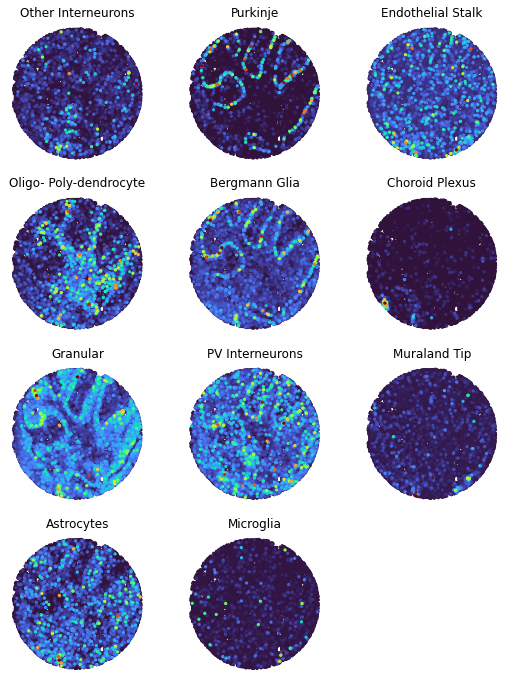

In [10]:
tg.plot_cell_annotation(ad_map, annotation='cluster', nrows=4, ncols=3, cmap='turbo')

In [17]:
# ad_sc.X.sum(axis=1)

In [7]:
ad_ge = tg.project_genes(adata_map=ad_map, adata_sc=ad_sc)
ad_ge

AnnData object with n_obs × n_vars = 13630 × 2505
    obs: 'x', 'y'
    var: 'is_training'

In [19]:
ad_map.uns['train_genes_df'].head(10)

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
RP23-403P24.5,0.996897,0.998011,0.999633,0.001623
Gm38148,0.987113,0.999847,0.999927,0.000080
2900055J20Rik,0.981902,0.995562,0.999927,0.004364
Adamtsl1,0.976374,0.997896,0.999413,0.001517
RP23-7E4.3,0.971567,0.999350,0.999927,0.000577
Gm16099,0.970258,0.999579,0.999633,0.000054
Cdk15,0.969815,0.998967,0.999853,0.000886
Cybb,0.965938,0.999503,0.999927,0.000424
Dqx1,0.964556,0.999082,0.999046,-0.000036
Sst,0.964496,0.999235,0.999413,0.000178


/home/myp2113/miniconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


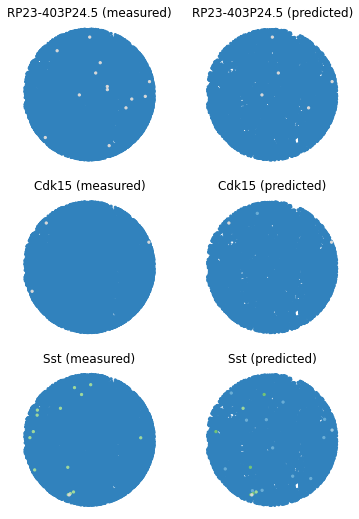

In [8]:
# high-score genes
genes = ['RP23-403P24.5', 'Cdk15', 'Sst']
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge, cmap='tab20c')

In [21]:
ad_map.uns['train_genes_df'].tail(20)

,train_score,sparsity_sc,sparsity_sp,sparsity_diff
Apba2,0.194974,0.769693,0.989068,0.219375
Smarca4,0.194387,0.833850,0.991563,0.157713
Tcerg1,0.192934,0.833123,0.991930,0.158807
Smc6,0.191310,0.819503,0.989729,0.170225
Snw1,0.189806,0.746318,0.984886,0.238569
Sltm,0.188977,0.708941,0.986867,0.277927
Gm10800,0.186666,0.684150,0.996698,0.312548
Ddx46,0.183457,0.831019,0.992003,0.160984
Arid4a,0.182516,0.779754,0.991930,0.212175
Tenm1,0.178765,0.809595,0.992150,0.182555


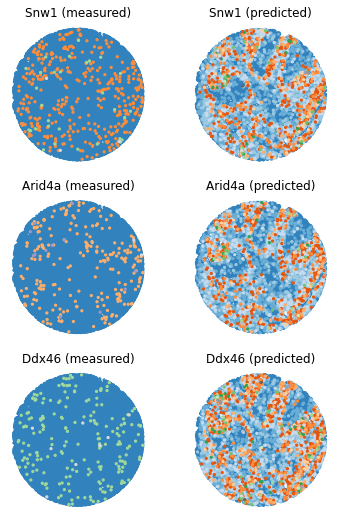

In [9]:
# low-score genes
genes = ['Snw1', 'Arid4a', 'Ddx46']
tg.plot_genes(genes, adata_measured=ad_sp, adata_predicted=ad_ge, cmap='tab20c')

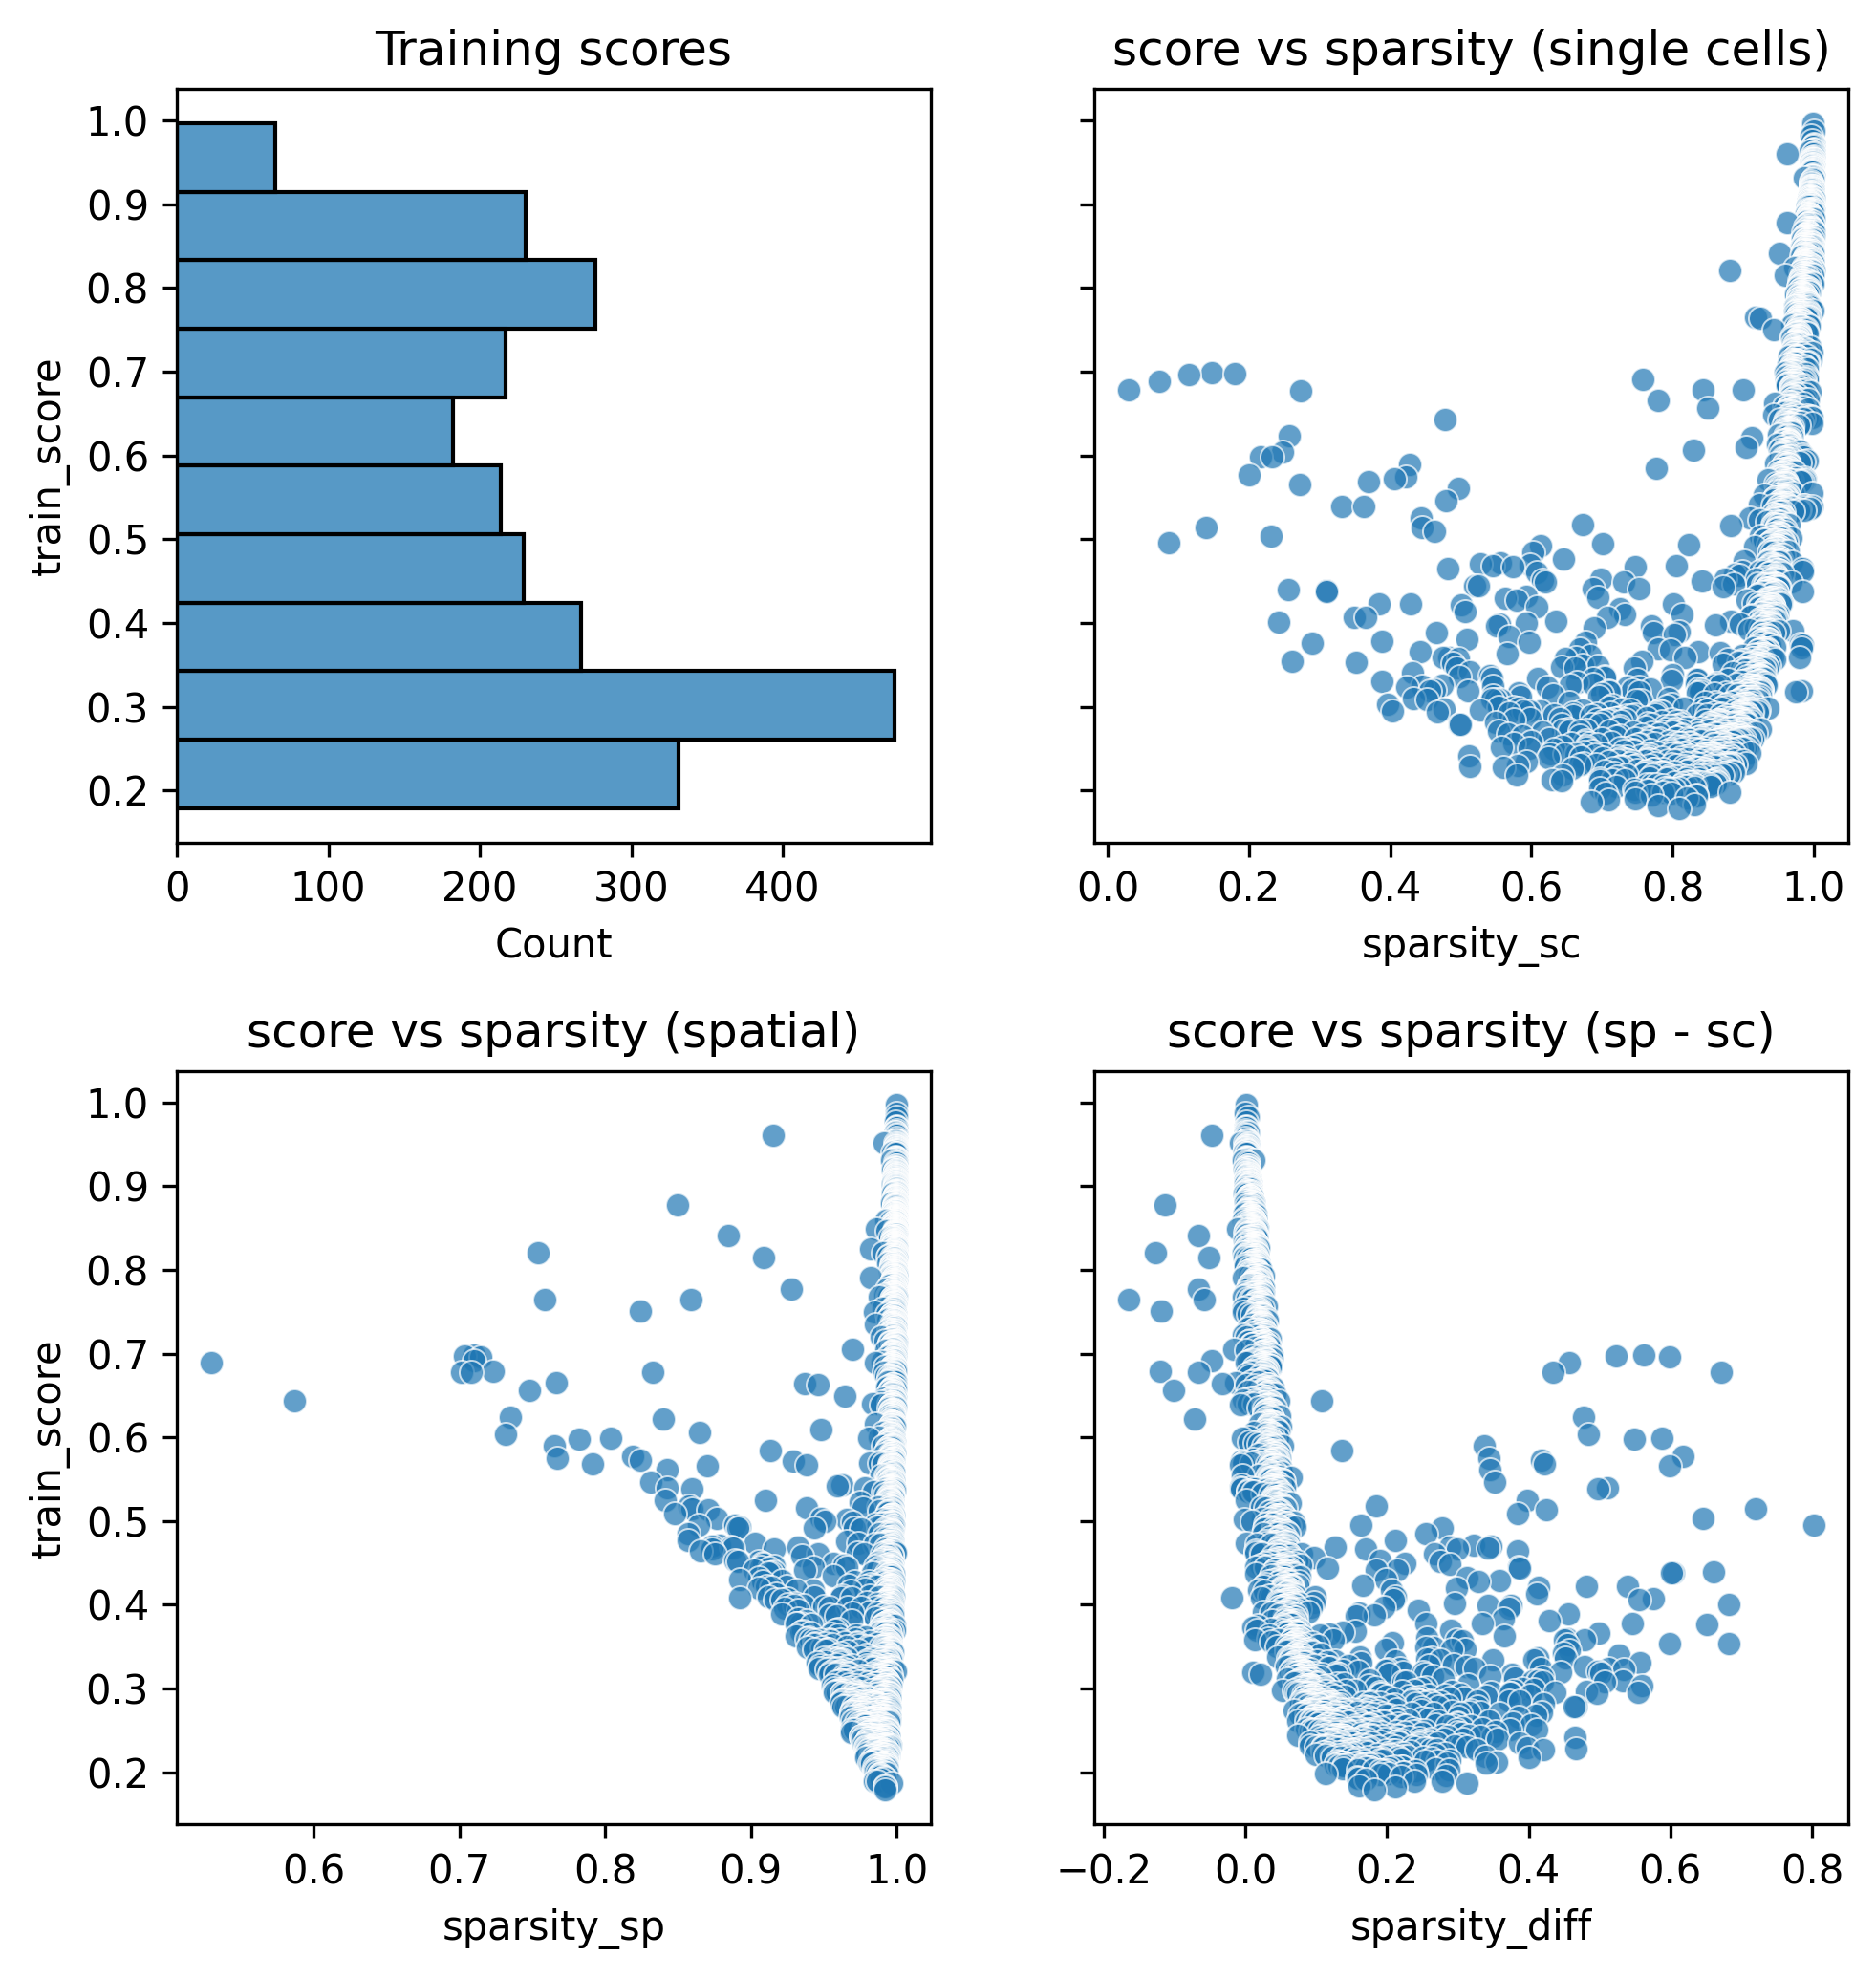

In [23]:
tg.plot_training_scores(ad_map)